Importing Libs

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Reading Dataset using keras

In [52]:
path = "../Dataset/BinDataset"
batch_size = 32
img_height = 64
img_width = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 41330 files belonging to 2 classes.
Using 33064 files for training.


In [53]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 41330 files belonging to 2 classes.
Using 8266 files for validation.


In [54]:
class_names = train_ds.class_names
print(class_names)

['NotSuspicious', 'Suspicious']


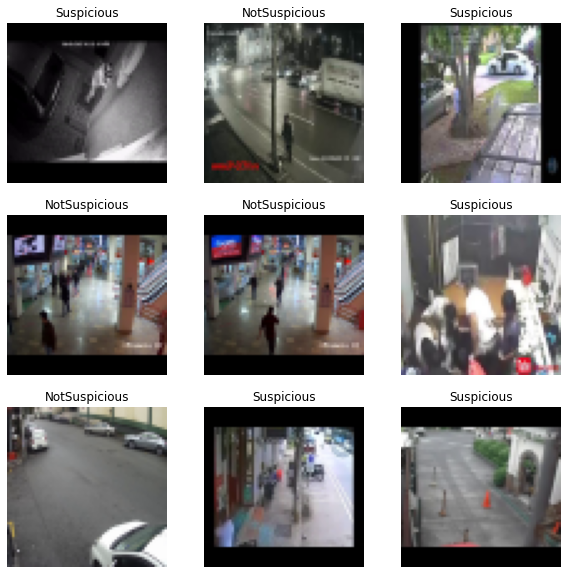

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Below is a time taking process it gets image shaoe and labels shape

In [57]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

Reducing the pixel values to the range of 0 to 1

In [58]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97647065


In [132]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.2),
  # layers.Dense(32, activation='relu'),
  # layers.Dropout(0.2),
  # layers.Dense(num_classes,activation='relu'),
  layers.Dense(1,activation='sigmoid')
])

In [133]:
# model.compile(optimizer='adam',
#               loss=keras.losses.binary_crossentropy,
#               metrics=['accuracy'])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_crossentropy','accuracy']
              )

In [134]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_44 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 64)      

In [137]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  shuffle=True,
  epochs=epochs,
  use_multiprocessing=True
)

Epoch 1/10
1034/1034 [==============================] - 64s 62ms/step - loss: 0.1200 - binary_crossentropy: 0.1200 - accuracy: 0.9499 - val_loss: 0.0111 - val_binary_crossentropy: 0.0111 - val_accuracy: 0.9977
Epoch 2/10
1034/1034 [==============================] - 62s 60ms/step - loss: 0.0234 - binary_crossentropy: 0.0234 - accuracy: 0.9907 - val_loss: 0.0047 - val_binary_crossentropy: 0.0047 - val_accuracy: 0.9990
Epoch 3/10
1034/1034 [==============================] - 62s 60ms/step - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.9931 - val_loss: 0.0116 - val_binary_crossentropy: 0.0116 - val_accuracy: 0.9990
Epoch 4/10
1034/1034 [==============================] - 62s 60ms/step - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.9921 - val_loss: 0.0057 - val_binary_crossentropy: 0.0057 - val_accuracy: 0.9994
Epoch 5/10
1034/1034 [==============================] - 63s 61ms/step - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.9950 - val_loss: 0.0047 - val_b

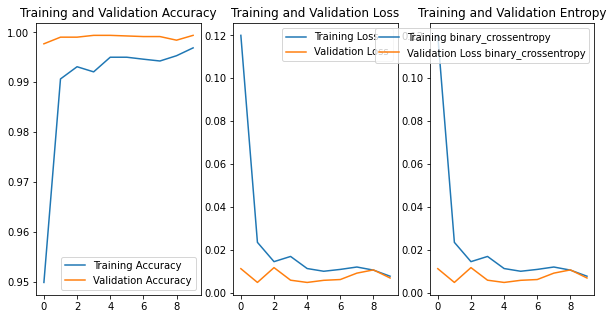

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

binary_crossentropy = history.history['binary_crossentropy']
val_binary_crossentropy = history.history['val_binary_crossentropy']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, binary_crossentropy, label='Training binary_crossentropy')
plt.plot(epochs_range, val_binary_crossentropy, label='Validation Loss binary_crossentropy')
plt.legend(loc='upper right')
plt.title('Training and Validation Entropy')





plt.show()

In [166]:
test_image_path =  "../Dataset\BinDataset\Suspicious\Assault006_x264_80.png"
# "../Dataset/BinDataset/NotSuspicious/Normal_Videos_944_x264_7110.png"
# "../testing_data/mtext.jpg"

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
classes = predictions.argmax(axis=-1)
score = tf.nn.sigmoid(predictions[0])

print(predictions[0][0])
class_index = predictions[0][0] > 0.5 and 1 or 0

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[class_index], 100 * np.max(score))
)

1.0
This image most likely belongs to Suspicious with a 73.11 percent confidence.


In [167]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('../trained_model/my_model.h5')

In [168]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('../trained_model/my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_44 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 64)      